In [3]:
import pandas as pd
from google.colab import drive

# 1. 구글 드라이브 마운트 (승인 팝업이 뜨면 '허용'을 눌러주세요)
drive.mount('/content/drive')

# 2. 파일 경로 설정 (구글 드라이브 내 실제 파일 경로로 수정해주세요)
# 예: '/content/drive/MyDrive/폴더명/파일명.csv'
path1 = '/content/drive/MyDrive/251223/VIP_merged_result_columns_select_78cols.csv'
path2 = '/content/drive/MyDrive/251223/vip_final_churn_score_result_59364_9.csv'

# 3. 데이터 불러오기 (인코딩 처리 포함)
def load_csv(path):
    try:
        return pd.read_csv(path, encoding='utf-8-sig')
    except:
        return pd.read_csv(path, encoding='cp949')

df_usage = load_csv(path1)
df_balance = load_csv(path2)

# 4. 데이터 병합 (Merge)
# '발급회원번호'를 기준으로 옆으로(how='inner') 합칩니다.
# 만약 한 회원의 데이터가 여러 달(기준년월)로 나뉘어 있다면,
# on=['발급회원번호', '기준년월'] 처럼 두 개를 모두 써야 중복 데이터가 생기지 않습니다.
df= pd.merge(df_usage, df_balance, on=['발급회원번호', '기준년월'], how='inner')

# 5. 결과 확인
print(f"첫 번째 파일 크기: {df_usage.shape}")
print(f"두 번째 파일 크기: {df_balance.shape}")
print(f"병합 후 파일 크기: {df.shape}")
df.head()

# (선택 사항) 병합된 결과를 다시 구글 드라이브에 저장하고 싶을 때
# df_merged.to_csv('/content/drive/MyDrive/your_folder/merged_result.csv', index=False, encoding='utf-8-sig')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
첫 번째 파일 크기: (59364, 78)
두 번째 파일 크기: (59364, 9)
병합 후 파일 크기: (59364, 85)


,기준년월,발급회원번호,증감율_이용금액_신판_전월,증감율_이용금액_일시불_전월,증감율_이용건수_신용_분기,증감율_이용금액_신용_분기,증감율_이용금액_일시불_분기,잔액_신판평균한도소진율_r6m,잔액_신판최대한도소진율_r6m,잔액_신판ca평균한도소진율_r6m,...,최종유효년월_신용_이용가능,최종유효년월_신용_이용,최종카드발급경과월,Slope_Spend,Slope_Balance,Slope_Count,Risk_Flag,Churn_Score_Slope,Churn_Score_Total_Scaled,Final_Combined_Score
0,201807,SYN_100022,0.260559,0.260559,-0.116826,0.003011,0.003011,0.315508,0.410814,0.324979,...,201910.0,202001.0,47,0.0,0.0,0.0,0,0.0,0.155725,0.1
1,201808,SYN_100022,0.301082,0.301082,-0.387184,-0.303957,-0.303957,0.319732,0.402875,0.338338,...,202001.0,202001.0,48,40719.0,882129.0,-5.0,0,4.3,0.155756,2.2
2,201809,SYN_100022,0.234625,0.234625,-0.294737,-0.355487,-0.355487,0.371649,0.414520,0.405172,...,201910.0,201912.0,49,-5992.5,441733.0,-1.0,0,1.0,0.155745,0.6
3,201810,SYN_100022,0.276458,0.276458,-0.156311,-0.158050,-0.158050,0.349783,0.369626,0.387961,...,202003.0,202005.0,50,-28130.0,182261.0,0.5,0,0.6,0.155749,0.4
4,201811,SYN_100022,0.262132,0.262132,-0.098511,-0.038224,-0.038224,0.327325,0.363699,0.351894,...,202003.0,202005.0,51,47550.0,350593.0,2.5,0,0.0,0.155736,0.1


In [5]:
X = df[['Final_Combined_Score']].values

In [6]:
from sklearn.cluster import KMeans
# 클러스터 개수를 3개로 설정하고 모델 생성 (결과의 일관성을 위해 random_state 고정)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# 모델 학습 및 클러스터 예측 결과 추가
df['Cluster'] = kmeans.fit_predict(X)

# 각 클러스터에 몇 명의 고객이 배정되었는지 확인해볼까?
print(df['Cluster'].value_counts().sort_index())

Cluster
0    49194
1      390
2     9780
Name: count, dtype: int64


Text(0, 0.5, 'Final Combined Score')

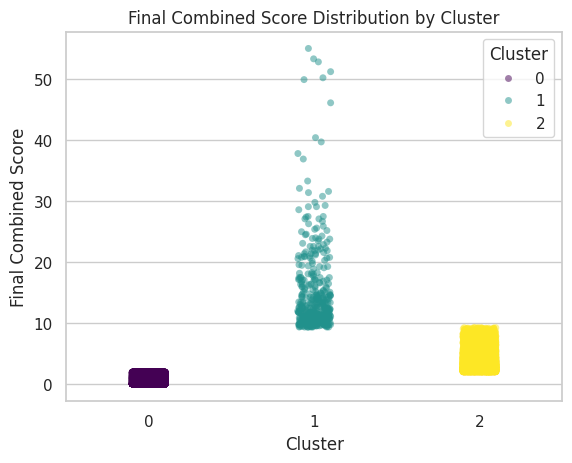

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 스타일 설정
sns.set_theme(style="whitegrid")

# 클러스터별 점수 분포를 보기 위한 Strip Plot
sns.stripplot(x='Cluster', y='Final_Combined_Score', data=df, hue='Cluster', palette='viridis', jitter=True, alpha=0.5)

# 그래프 제목 및 라벨 설정
plt.title('Final Combined Score Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Final Combined Score')

# 그래프 저장
# plt.savefig('cluster_distribution.png')

In [8]:
# Cluster 정보를 바탕으로 Target 변수 생성
# 0: 유지(Cluster 0), 1: 이탈 위험(Cluster 1, 2)
df['Target'] = df['Cluster'].map({0: 0, 1: 1, 2: 1})

# 잘 바뀌었는지 상위 데이터만 살짝 확인해볼까?
print(df[['Final_Combined_Score', 'Cluster', 'Target']].head())

   Final_Combined_Score  Cluster  Target
0                   0.1        0       0
1                   2.2        2       1
2                   0.6        0       0
3                   0.4        0       0
4                   0.1        0       0


In [9]:
df['Target'].value_counts()

,count
Target,
0,49194
1,10170


In [10]:
df.head()

,기준년월,발급회원번호,증감율_이용금액_신판_전월,증감율_이용금액_일시불_전월,증감율_이용건수_신용_분기,증감율_이용금액_신용_분기,증감율_이용금액_일시불_분기,잔액_신판평균한도소진율_r6m,잔액_신판최대한도소진율_r6m,잔액_신판ca평균한도소진율_r6m,...,최종카드발급경과월,Slope_Spend,Slope_Balance,Slope_Count,Risk_Flag,Churn_Score_Slope,Churn_Score_Total_Scaled,Final_Combined_Score,Cluster,Target
0,201807,SYN_100022,0.260559,0.260559,-0.116826,0.003011,0.003011,0.315508,0.410814,0.324979,...,47,0.0,0.0,0.0,0,0.0,0.155725,0.1,0,0
1,201808,SYN_100022,0.301082,0.301082,-0.387184,-0.303957,-0.303957,0.319732,0.402875,0.338338,...,48,40719.0,882129.0,-5.0,0,4.3,0.155756,2.2,2,1
2,201809,SYN_100022,0.234625,0.234625,-0.294737,-0.355487,-0.355487,0.371649,0.414520,0.405172,...,49,-5992.5,441733.0,-1.0,0,1.0,0.155745,0.6,0,0
3,201810,SYN_100022,0.276458,0.276458,-0.156311,-0.158050,-0.158050,0.349783,0.369626,0.387961,...,50,-28130.0,182261.0,0.5,0,0.6,0.155749,0.4,0,0
4,201811,SYN_100022,0.262132,0.262132,-0.098511,-0.038224,-0.038224,0.327325,0.363699,0.351894,...,51,47550.0,350593.0,2.5,0,0.0,0.155736,0.1,0,0


In [12]:
# pip install LightGBM as lgb

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [17]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import accuracy_score

In [15]:

# ============================================================================
# 핵심 1: 불필요한 컬럼 정의
# ============================================================================
target_col = 'Target'  # 정답지
drop_cols = ['Slope_Spend','Slope_Balance','Slope_Count', '발급회원번호', '기준년월',
    'Risk_Flag','Churn_Score_Slope','Churn_Score_Total_Scaled','Final_Combined_Score','Cluster','Target'
    ]
#'이용금액_신용_B0M',  '이용건수_신용_B0M','잔액_B0M'
# ============================================================================
# 핵심 2: 월별로 데이터 쪼개기 (Time Split)
# ============================================================================
# 1) 학습 데이터 (7, 8, 9, 10월)
train_df = df[df['기준년월'].isin([201807, 201808, 201809, 201810])]

# 2) 검증 데이터 (11월) - 모델 채점용
valid_df = df[df['기준년월'] == 201811]

# 3) 실전 예측 데이터 (12월) - 정답(Target)이 없는 미래 데이터
predict_df = df[df['기준년월'] == 201812]

# ============================================================================
# 핵심 3: X(문제), y(정답) 나누기
# ============================================================================
X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target_col]

X_valid = valid_df.drop(columns=drop_cols)
y_valid = valid_df[target_col]

X_predict = predict_df.drop(columns=drop_cols)
predict_ids = predict_df['발급회원번호'] # 결과 매칭용 ID 킵

# 문자열 -> category 변환 (LightGBM 최적화)
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')
        X_predict[col] = X_predict[col].astype('category')

# ============================================================================
# 핵심 4: 모델 학습
# ============================================================================
model = lgb.LGBMClassifier(n_estimators=1000, random_state=42, verbose=-1)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# ============================================================================
# 핵심 5: 12월 고객에 대한 이탈 확률 예측 및 결과 저장
# ============================================================================
pred_prob = model.predict_proba(X_predict)[:, 1]

# 결과 정리
final_result = pd.DataFrame({
    '발급회원번호': predict_ids,
    '이탈예측확률': pred_prob
})

# 결과 정리
final_result = pd.DataFrame({
    '발급회원번호': predict_ids,
    '이탈예측확률': pred_prob
})

print(final_result.sort_values('이탈예측확률', ascending=False).head(10))

# # 드라이브에 결과 저장 (CSV)
# final_result.to_csv(output_path, index=False, encoding='utf-8-sig')

# print(f"예측 결과가 다음 경로에 저장되었습니다: {output_path}")
# print(final_result.sort_values('이탈예측확률', ascending=False).head(10))

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[333]	valid_0's binary_logloss: 0.31303
            발급회원번호    이탈예측확률
34487  SYN_2553493  0.972532
42521  SYN_2946466  0.962071
39035  SYN_2778092  0.957498
58727   SYN_970882  0.945460
19715  SYN_1896900  0.941898
19271  SYN_1880379  0.937359
50849   SYN_631608  0.923681
31253  SYN_2410781  0.922246
14747  SYN_1680282  0.921115
15161  SYN_1701118  0.919658


In [18]:
pred_valid = model.predict(X_valid)
print("검증(11월) 정확도:", accuracy_score(y_valid, pred_valid))

검증(11월) 정확도: 0.8703254497675359
